# Configurations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.decomposition
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
import seaborn as sns; sns.set()
import math
from typing import List
from types import SimpleNamespace

# Temporary
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Data Loading

In [ ]:
# The column names in the NSL KDD dataset
col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label",               # <-- attack label
    "difficulty"           # <-- the missing column!
]

train = pd.read_csv("KDDTrain+.txt", names=col_names)
test  = pd.read_csv("KDDTest+.txt",  names=col_names)

# Selected features
features = [
    # categorical
    "protocol_type", "service", "flag",

    # numeric
    "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "dst_host_srv_count", "dst_host_serror_rate",
    "logged_in", "root_shell", "su_attempted"
]

categorical = ["protocol_type", "service", "flag"]

numeric = [
    "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "dst_host_srv_count", "dst_host_serror_rate",
    "logged_in", "root_shell", "su_attempted"
]

preprocess = ColumnTransformer([ ("cat", OneHotEncoder(handle_unknown="ignore"), categorical), ("num", "passthrough", numeric) ])

# Training and testing set
X_train = train[features]
X_test  = test[features]

# Ensure string values are numerical
X_train = preprocess.fit_transform(X_train).toarray()
X_test  = preprocess.transform(X_test).toarray()

# Label normal traffic as 0 and attack traffic 1
y_train = (train["label"] != "normal").astype(int).values
y_test  = (test["label"] != "normal").astype(int).values

# Shape of data
num_features = X_train.shape[1] # 94 features
N = len(X_train)                # 

# Set validation size to 20%
val_size = int(0.2 * N)

# Validation set
X_val = X_train[:val_size]
y_val = y_train[:val_size]

# Training set
X_train = X_train[val_size:]
y_train = y_train[val_size:]

In [102]:
print(X_test.shape)

(22544, 94)


# Dimensionality Reduction

In [ ]:
def plot_embedding(embedding, labels, title=None):
    """ Plot 2D scatter.

    Args:
        embedding (ndarray): data of size (N, 2)
        labels (ndarray):    labels of size (N, )
        title (str):         title of the plot
    """
    assert embedding.shape[1] == 2

    colors = np.where(labels == 1, 'blue', 'green')

    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, alpha=0.5, s=5 )

    plt.scatter([], [], c='green', label='0')
    plt.scatter([], [], c='blue', label='1')
    plt.legend()

    plt.axis('equal')
    if title:
        plt.title(title)

<Axes: title={'center': 'Implementation'}>

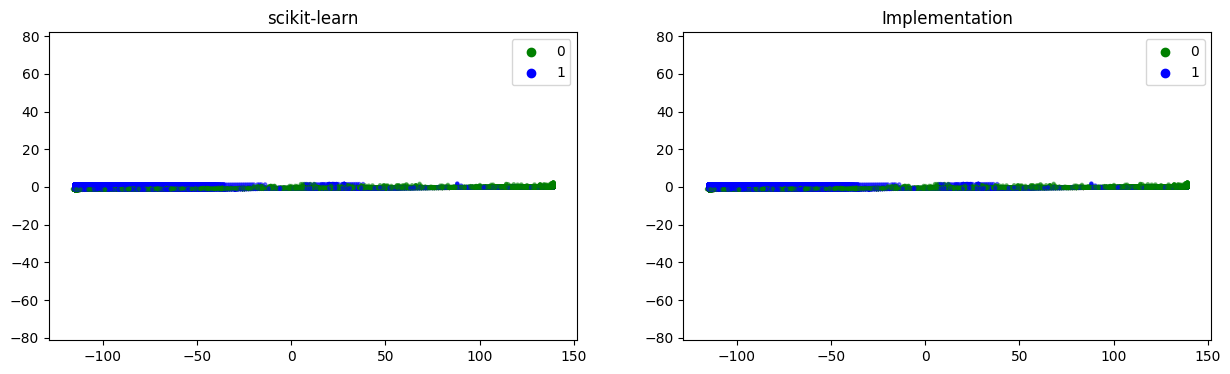

In [ ]:
def pca(X, comp):
    """ Project data onto principal components.

    Args:
        X (np.ndarray):   data of size (N, num_features)
        comp (list(int)): specific principal components
    
    Returns:
        (ndarray): projected data
    """
    # Compute data covariance matrix
    X_cen = X - np.mean(X, axis=0)             # Centered data (N, num_features)
    X_cov = (X_cen.T @ X_cen) / X.shape[0]     # Covariance (num_features, num_features)

    # Compute eigenvectors of the matrix
    e_vals, e_vecs = np.linalg.eig(X_cov)       # Eigenvalues (num_features,) and Eigenvectors (num_features,num_features)
    sorted_idxs = np.argsort(e_vals)[::-1]      # Sort indices of largest eignevalues
    e_vecs = e_vecs[:,sorted_idxs]              # Sorted eigenvectors with largest eigenvalues

    # Compute projection of data onto selected eigenvectors
    X_proj = X_cen @ e_vecs[:,comp] # If 2D (N, num_features) x (num_features, 2) -> (N, 2)
    return X_proj

plt.subplots(1, 2, figsize=(15, 4))
embedding1 = pca(X_train, [0, 1])
embedding2 = sklearn.decomposition.PCA(n_components=2).fit_transform(X_train)
plot_embedding(embedding1, y_train, 'Implementation')
plt.subplot(1, 2, 1)
plot_embedding(embedding2, y_train, 'scikit-learn')
plt.subplot(1, 2, 2)

# Logistic Regression

In [ ]:
def sigmoid(z):
    """Sigmoid function."""
    return np.exp(-np.logaddexp(0, -z))

In [ ]:
def predict_logistic_regression(Xs, w):
    """Predict labels via using sigmoid function and decision rule"""
    preds_prob = Xs @ w[1:] + w[0]                          # Compute the probabilities via sigmoid(X*w + b)
    preds_val = (sigmoid(preds_prob) >= 0.5).astype(int)    # Classifying according to decision rule
    return preds_val

## Stochastic Gradient Descent (SGD)

In [ ]:
def get_batch(xs, ys, B):
    """Return a random mini‑batch of size B from (xs, ys)."""
    assert len(xs) == len(ys), "xs and ys must contain the same number of samples."

    # Initialize batch arrays
    x_batch = np.zeros((B, xs.shape[1]))
    y_batch = np.zeros((B, 1))

    # Randomly sample B indices from the dataset
    idxs = np.random.randint(0, len(ys), size=B)

    # Fill the batch
    x_batch,y_batch = xs[idxs], ys[idxs]
    return x_batch, y_batch

In [ ]:
def logistic_regression_gradient(xs_batch, ys_batch, w, alfa):
    """ Compute the gradients of the binary cross entropy loss w.r.t weights and bias for logistric regression using sigmoid function

    Args:
        xs_batch (ndarray): input data with size [B x num_features]
        ys_batch (ndarray): output labels with size [B x 1]
        w (ndarray): weights with size [num_features+1]

    Returns:
        ndarray: gradient_w (includes bias as w[0])
    """
    assert len(xs_batch) == len(ys_batch), "Incompatible number of elements!"
    assert len(w) == xs_batch.shape[1] + 1, "w must include bias term!"

    B = xs_batch.shape[0]

    # Prepend a column of ones to xs_batch for the bias term
    Xb = np.zeros((B, num_features + 1))
    Xb[:, 0] = 1.0
    Xb[:, 1:] = xs_batch

    # Compute before sigmoid Xb*w with dimensions (B, num_features+1) x (num_features+1,) -> (B,)
    z = Xb @ w

    # Compute sigmoid(z)- Y with dimension (B, 1)
    b = sigmoid(z).reshape(-1, 1) - ys_batch

    # Compute Xb^T * (sigmoid(z)- y_i) with dimension (num_features+1, 1)
    gradient_w = Xb.T @ b
    
    # L2 regularization
    grad_reg = alfa * w 
    grad_reg[0] = 0.0
    gradient_w = gradient_w + grad_reg.reshape(-1, 1)
    
    # Return gradient_w as 1D (num_features+1,)
    return gradient_w.ravel()

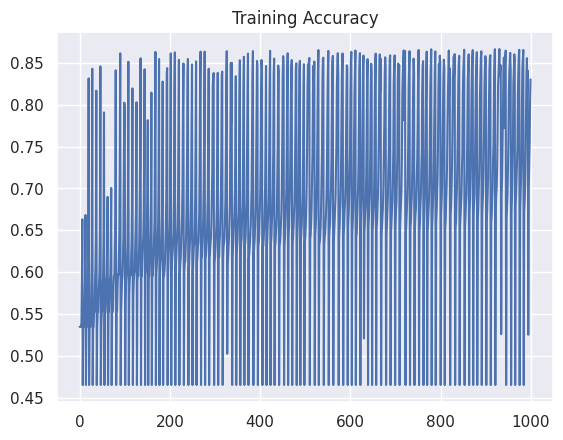

In [105]:
def stochastic_gradient_descent(xs, ys, T=10**4, lr=10**(-3), B=16, alfa=10**(-3)):
    """Compute SDG to optimize the weights and bias for the model

    Args:
        xs (ndarray): input data with size (N, num_features)
        ys (ndarray): output data, the labels with size (N,)
        T (int, optional): iterations. Defaults to 10**4.
        lr (float, optional): learning rate. Defaults to 10**(-3).
        B (int, optional): batch size. Defaults to 16.

    Returns:
        (ndarray), (ndarray)  : the weights with size (num_features,), bias and model accuracy with size (T,)
    """
    w = np.ones(num_features + 1)   # w[0] = bias
    ws = np.zeros(shape=[T, num_features+1]) # store the w vector here at each step
    accuracy = np.zeros(T)

    for t in range(T):
        # Random sampling over dataset
        xs_batch, ys_batch = get_batch(xs, ys, B)      # Dimensions (B, num_features), (B, 1)

        # Compute the gradient for w
        grad_w = logistic_regression_gradient(xs_batch, ys_batch, w, alfa) # Dimensions (num_features+1,)

        # Update parameters via theta = prev theta - learning rate * gradient
        w = w - lr * grad_w  # Dimensions (num_features,)
        ws[t] = w
        
        preds_prob = xs @ w[1:] + w[0]                          # Compute the probabilities via sigmoid(X*w + b)
        preds_label = (sigmoid(preds_prob) >= 0.5).astype(int)    # Classifying according to decision rule
        accuracy[t] = np.mean(preds_label == ys) # Sum correct prediction accross whole dataset and take the mean

    return w, accuracy
w, acc = stochastic_gradient_descent(X_train, y_train, T=10**3, B=256, alfa=1e-3)
plt.plot(acc) 
plt.title("Training Accuracy") 
plt.show()

# Generalization

## Performance Metrics

In [ ]:
def accuracy_score(y_true, y_pred):
    """Fraction of correct predictions"""
    acc = np.mean(y_true == y_pred)
    return acc

def confusion_matrix(y_true, y_pred):
    """Confusion matrix with TN, FP, FN, TP"""
    # Guess positive correctly
    TP = np.sum((y_pred == 1) & (y_true == 1))
    
    # Guess negative correctly
    TN = np.sum((y_pred == 0) & (y_true == 0))
    
    # Guess positive incorrectly
    FP = np.sum((y_pred == 1) & (y_true == 0))
    
    # Guess negative incorrectly
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    # Confusion matrix
    cm = [[TN, FP], [FN, TP]]                  
    s = sns.heatmap(cm, annot=True, cbar=True)
    s.set(ylabel='Ground truths', xlabel='Predictions')
    return cm

def precision_score(y_true, y_pred):
    """ Fraction of positive classifications that are correct """
    (_, FP), (_, TP) = confusion_matrix(y_true, y_pred)
    precision = TP / (TP + FP)
    return precision

def recall_score(y_true, y_pred):
    """Fraction of true positives that are correctly classified"""
    _, (FN, TP) = confusion_matrix(y_true, y_pred)
    recall = TP / (TP + FN)
    return recall

def f1_score(y_true, y_pred):
    """Harmonic mean of precision and recall."""
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

## Grid search

best learning rate =  0.0005 with acc_val =  0.8946971501151068  and alfa =  0.001


Text(0.002, 1.0, 'maximum Acc')

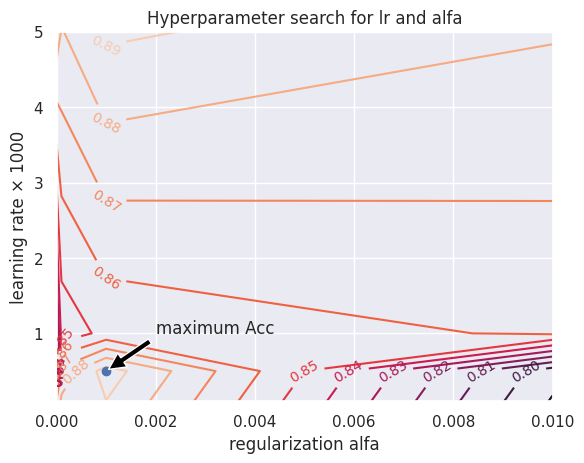

In [106]:
# Selected learning rate values
lrs  = [1e-4, 5e-4, 1e-3, 5e-3]

# Selected regularization strengths
alfas = [0.0, 1e-4, 1e-3, 1e-2]

Acc_by_lr_by_alfa = np.zeros((len(lrs), len(alfas)))

best_acc  = -1.0
best_lr   = None
best_alfa = None

# Grid search over learning rate and regularization
for lr_idx, lr in enumerate(lrs):
    for a_idx, alfa in enumerate(alfas):

        # Train logistic regression with these hyperparameters
        w, _ = stochastic_gradient_descent(X_train, y_train, T=10**4,lr=lr, B=256, alfa=alfa)

        # Validation predictions
        preds_prob = X_val @ w[1:] + w[0]                          # Compute the probabilities via sigmoid(X*w + b)
        preds_label = (sigmoid(preds_prob) >= 0.5).astype(int)    # Classifying according to decision rule

        # Validation accuracy
        acc = accuracy_score(y_val, preds_label)

        Acc_by_lr_by_alfa[lr_idx, a_idx] = acc

        # Track best hyperparameters
        if acc > best_acc:
            best_acc, best_lr, best_alfa = acc, lr, alfa

print('best learning rate = ', best_lr, 'with acc_val = ', best_acc,' and alfa = ', best_alfa)
fig, ax = plt.subplots()

lrs_scaled = np.array(lrs) * 1000
best_lr_scaled = best_lr * 1000

CS = ax.contour(alfas, lrs_scaled, Acc_by_lr_by_alfa, 10)
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Hyperparameter search for lr and alfa')
ax.set_xlabel('regularization alfa')
ax.set_ylabel('learning rate × 1000')

ax.plot(best_alfa, best_lr_scaled, 'o')
ax.annotate('maximum Acc',
            xy=(best_alfa, best_lr_scaled),
            xytext=(best_alfa + 0.001, best_lr_scaled + 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

## Evaluation

Training accuracy 0.8921997638396888
Test accuracy 0.7155784244144784
Precision 0.9409421782722154
Recall 0.5338580222862932
F1 score 0.6812170627423686


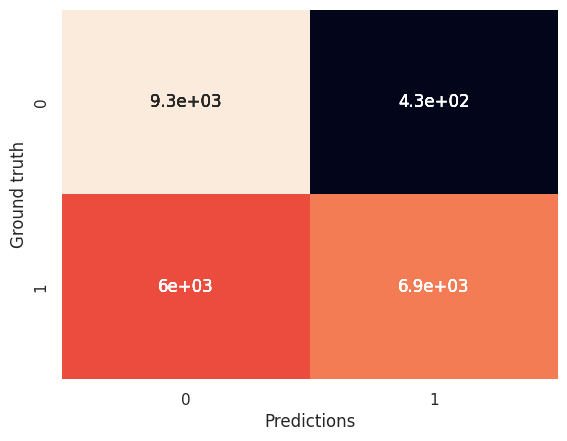

In [107]:
# Best model
w, acc = stochastic_gradient_descent(X_train, y_train, T=10**4, lr=best_lr, B=256, alfa=best_alfa)
print('Training accuracy',acc[len(acc)-1])

# Compute test predictions
preds_prob = X_test @ w[1:] + w[0]                          # Compute the probabilities via sigmoid(X*w + b)
preds_label = (sigmoid(preds_prob) >= 0.5).astype(int)      # Classifying according to decision rule

# Compute test accuracy
acc = accuracy_score(y_test, preds_label)
confusion_matrix(y_test, preds_label)
prec = precision_score(y_test, preds_label)
rec = recall_score(y_test, preds_label)
f1 = f1_score(y_test, preds_label)

# Print results
print('Test accuracy',acc)
print('Precision', prec)
print('Recall', rec)
print('F1 score', f1)